In [14]:
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

from lib.data import conditions as cond
from lib.data import tables as tab
from lib.features import decomposition as de

In [2]:
np.random.seed(42)
plt.rc('svg', fonttype='none')

# Load data

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

Get the IDs of all cells that were added to the dataset on the first day.

In [4]:
day_one_cells = (
    session.query(tab.Cell)
    .join(tab.Cell.traces, tab.Trial)
    .filter(tab.Trial.day == 1)
    .subquery()
)

Get the average traces for non-catch trials of `day_one_cells` on days 1 and 7.

In [5]:
average_traces = []
days = []
cell_types = []
cell_ids = []
mouse_ids = []

for res in tqdm(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .join(tab.Mouse, day_one_cells.c.mouse_id==tab.Mouse.id)
        .filter(
            tab.TrialAverageTrace.day.in_([1, 7]), 
            tab.TrialAverageTrace.trial_kind == 'non_catch',
            tab.Mouse.cell_type != cond.CellType.som,  # Excluded b/c few neurons
            tab.Mouse.id != 'CL199',  # Excluded b/c fluorescence drift
        )
        .all()
):
    if not all(np.isnan(res[0].trace)):
        average_traces.append(res[0].trace)
        days.append(res[0].day)
        cell_ids.append(res[0].cell_id)
        cell_types.append(res[1].cell_type)
        mouse_ids.append(res[1].id)

100%|██████████| 3864/3864 [00:00<00:00, 175738.61it/s]


In [6]:
average_traces = np.array([tr[:390] for tr in average_traces])
days = np.array(days)
cell_types = np.array(cell_types)
cell_ids = np.array(cell_ids)

In [7]:
average_traces.shape

(3851, 390)

In [8]:
days

array([1, 7, 1, ..., 7, 1, 7])

In [9]:
cell_types

array([CellType.vip, CellType.vip, CellType.vip, ..., CellType.pv,
       CellType.pv, CellType.pv], dtype=object)

In [10]:
np.sum((days == 1) & (cell_types == cond.CellType.vip))

407

The data I imported has 483 VIP cells on day 1. If I did everything right, that should match your analysis.

# Helper function for saving figures

In [11]:
def savefig(fig_basename, **kwargs):
    for extension in ['png', 'svg']:
        print(f'Saving {extension}')
        plt.savefig('.'.join([fig_basename, extension]), **kwargs)

**Trial components**

Durations are in seconds.

In [15]:
trial_structure = de.TrialBasisFunctions(
    390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5
)

Trial structure is represented in terms of a set of rectangular functions. Here's one of them.

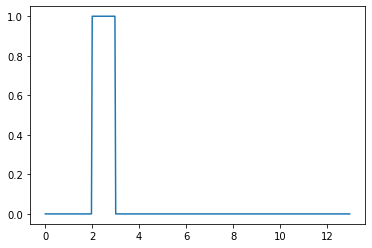

In [16]:
plt.plot(trial_structure.time, trial_structure.tone)

Which components are needed to capture trial structure? To find out, compute the cos similarity between a one-hot vector for each part of the trial and each component.

In [17]:
mean_fluorescence = {
    'tone': np.dot(
        average_traces, trial_structure.tone / trial_structure.tone.sum()
    ),
    'tone + delay': (
        np.dot(
            average_traces, (trial_structure.tone + trial_structure.delay) 
            / (trial_structure.tone + trial_structure.delay).sum()
        )
    ),
    'reward': np.dot(
        average_traces, trial_structure.reward / trial_structure.reward.sum()
    )
}

In [18]:
mean_fluo_df = pd.DataFrame(
    {
        'day': days,
        'cell_type': cell_types,
        'cell_id': cell_ids,
        'mouse_id': mouse_ids,
        **mean_fluorescence
    }
)
mean_fluo_df

,day,cell_type,cell_id,mouse_id,tone,tone + delay,reward
0,1,vip,3121,CL136,0.006833,-0.006349,-0.015298
1,7,vip,3121,CL136,0.056056,0.292485,0.064681
2,1,vip,3122,CL136,0.078297,0.026572,-0.122830
3,7,vip,3122,CL136,-0.027618,-0.061786,0.218031
4,1,vip,3123,CL136,-0.002098,0.013350,0.032032
...,...,...,...,...,...,...,...
3846,7,pv,2644,CL198,-0.107898,-0.029546,0.055185
3847,1,pv,2645,CL198,-0.010278,0.062069,0.016830
3848,7,pv,2645,CL198,-0.155872,-0.061751,0.062192
3849,1,pv,2646,CL198,-0.015687,0.043476,0.038258


In [19]:
mean_fluo_df.to_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv', index=False)

In [20]:
def mark_trial_structure():
    plt.axvspan(
        min(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        max(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        color='gray',
        label='Tone'
    )
    plt.axvline(
        min(trial_structure.time[trial_structure.reward]) - trial_structure.baseline_duration,
        color='gray',
        ls='--',
        label='Reward delivery',
    )

Cell types to show for tone + delay:      cell_type  tone + delay
1274       pyr      0.000105
1850       pyr     -0.907005
2224       pyr      0.502356
2272       pyr     -0.487087
2306       pyr      1.025276
Cell types to show for reward:      cell_type    reward
796         pv  0.500079
2272       pyr -0.502221
2534       pyr -1.048363
2852       pyr  1.001492
2978       pyr  0.000045
Saving png


<ipython-input-21-8277d037e9b0>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg


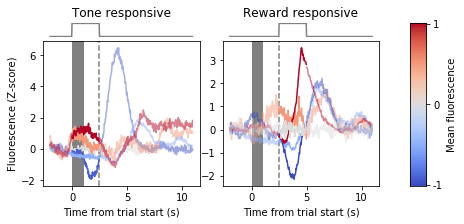

In [21]:
plt.figure(figsize=(7, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone responsive', 'Reward responsive'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    cells_to_show = np.unique(
        np.argmin(
            np.abs(
                mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].to_numpy() 
                - np.linspace(-1, 1, 5)[:, np.newaxis]  # Levels of cos similarity to find
            ),
            1
        )
    )
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j in range(len(means_)):
        component = traces_[:, j].copy()
        component[~mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            component,
            color=plt.cm.coolwarm(means_.iloc[j] * 0.5 + 0.5)
        )
        
        not_component = traces_[:, j].copy()
        not_component[mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            not_component,
            color=plt.cm.coolwarm(means_.iloc[j] * 0.5 + 0.5),
            alpha=0.5
        )

    if i == 0:
        plt.ylabel('Fluorescence (Z-score)')
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Mean fluorescence')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

In [22]:
FRAME_RATE = 30.0
BASELINE_DURATION = 2.
time_vec = np.arange(390) / FRAME_RATE - BASELINE_DURATION

Saving png
Saving svg


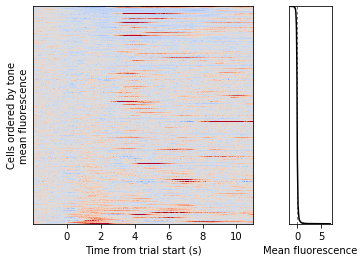

In [26]:
fluo_spec = gs.GridSpec(1, 2, width_ratios=[1, 0.15], wspace=0.0005)

plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by tone\nmean fluorescence')
plt.xlabel('Time from trial start (s)')

plt.subplot(fluo_spec[:, 1])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
#plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('Mean fluorescence')

savefig('../img/graphics/fluo_ordered_by_tone', dpi=600, bbox_inches='tight')

In [27]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'tone + delay'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.023385524133187684, pvalue=0.6556759784831028)

In [28]:
print(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'tone + delay'].to_numpy().flatten().size)
print(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'].to_numpy().flatten().size)

1926
1925


Saving png
Saving svg


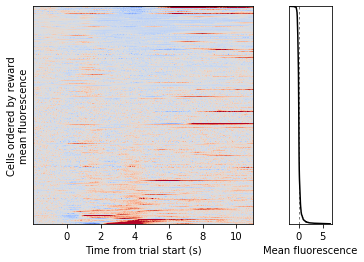

In [29]:
plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by reward\nmean fluorescence')
plt.xlabel('Time from trial start (s)')

plt.subplot(fluo_spec[:, 1])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
#plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('Mean fluorescence')

savefig('../img/graphics/fluo_ordered_by_reward', dpi=600, bbox_inches='tight')